# Downloading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing data for training

In [3]:
import tensorflow as tf

# ==== Paths ====
train_dir = '/content/drive/MyDrive/VGG/train'
val_dir   = '/content/drive/MyDrive/VGG/valid'
test_dir  = '/content/drive/MyDrive/VGG/test'

# ==== Parameters ====
img_size = (256, 256)  # 🔻 Reduced from 512x512
batch_size = 16        # 🔻 Reduced from 256
seed = 123

# ==== Load Datasets ====
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Optional: Normalize using EfficientNet’s preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.
Found 402 files belonging to 2 classes.


In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


# Preparing model for training

In [5]:
# num_classes = len(label_to_class_mapping)
num_classes=2

In [15]:
#https://keras.io/api/applications/
from tensorflow.keras import layers, models

pre_trained_model = tf.keras.applications.VGG16(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze VGG16 base
for layer in pre_trained_model.layers:
    layer.trainable = False

In [16]:
# Build model
inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
x = layers.Rescaling(1./255)(inputs)
x = pre_trained_model(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.5, name='dropout_dense_1')(x)

x = layers.Dense(256, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.5, name='dropout_dense_2')(x)

# Binary classification head
x = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

model = models.Model(inputs=inputs, outputs=x)

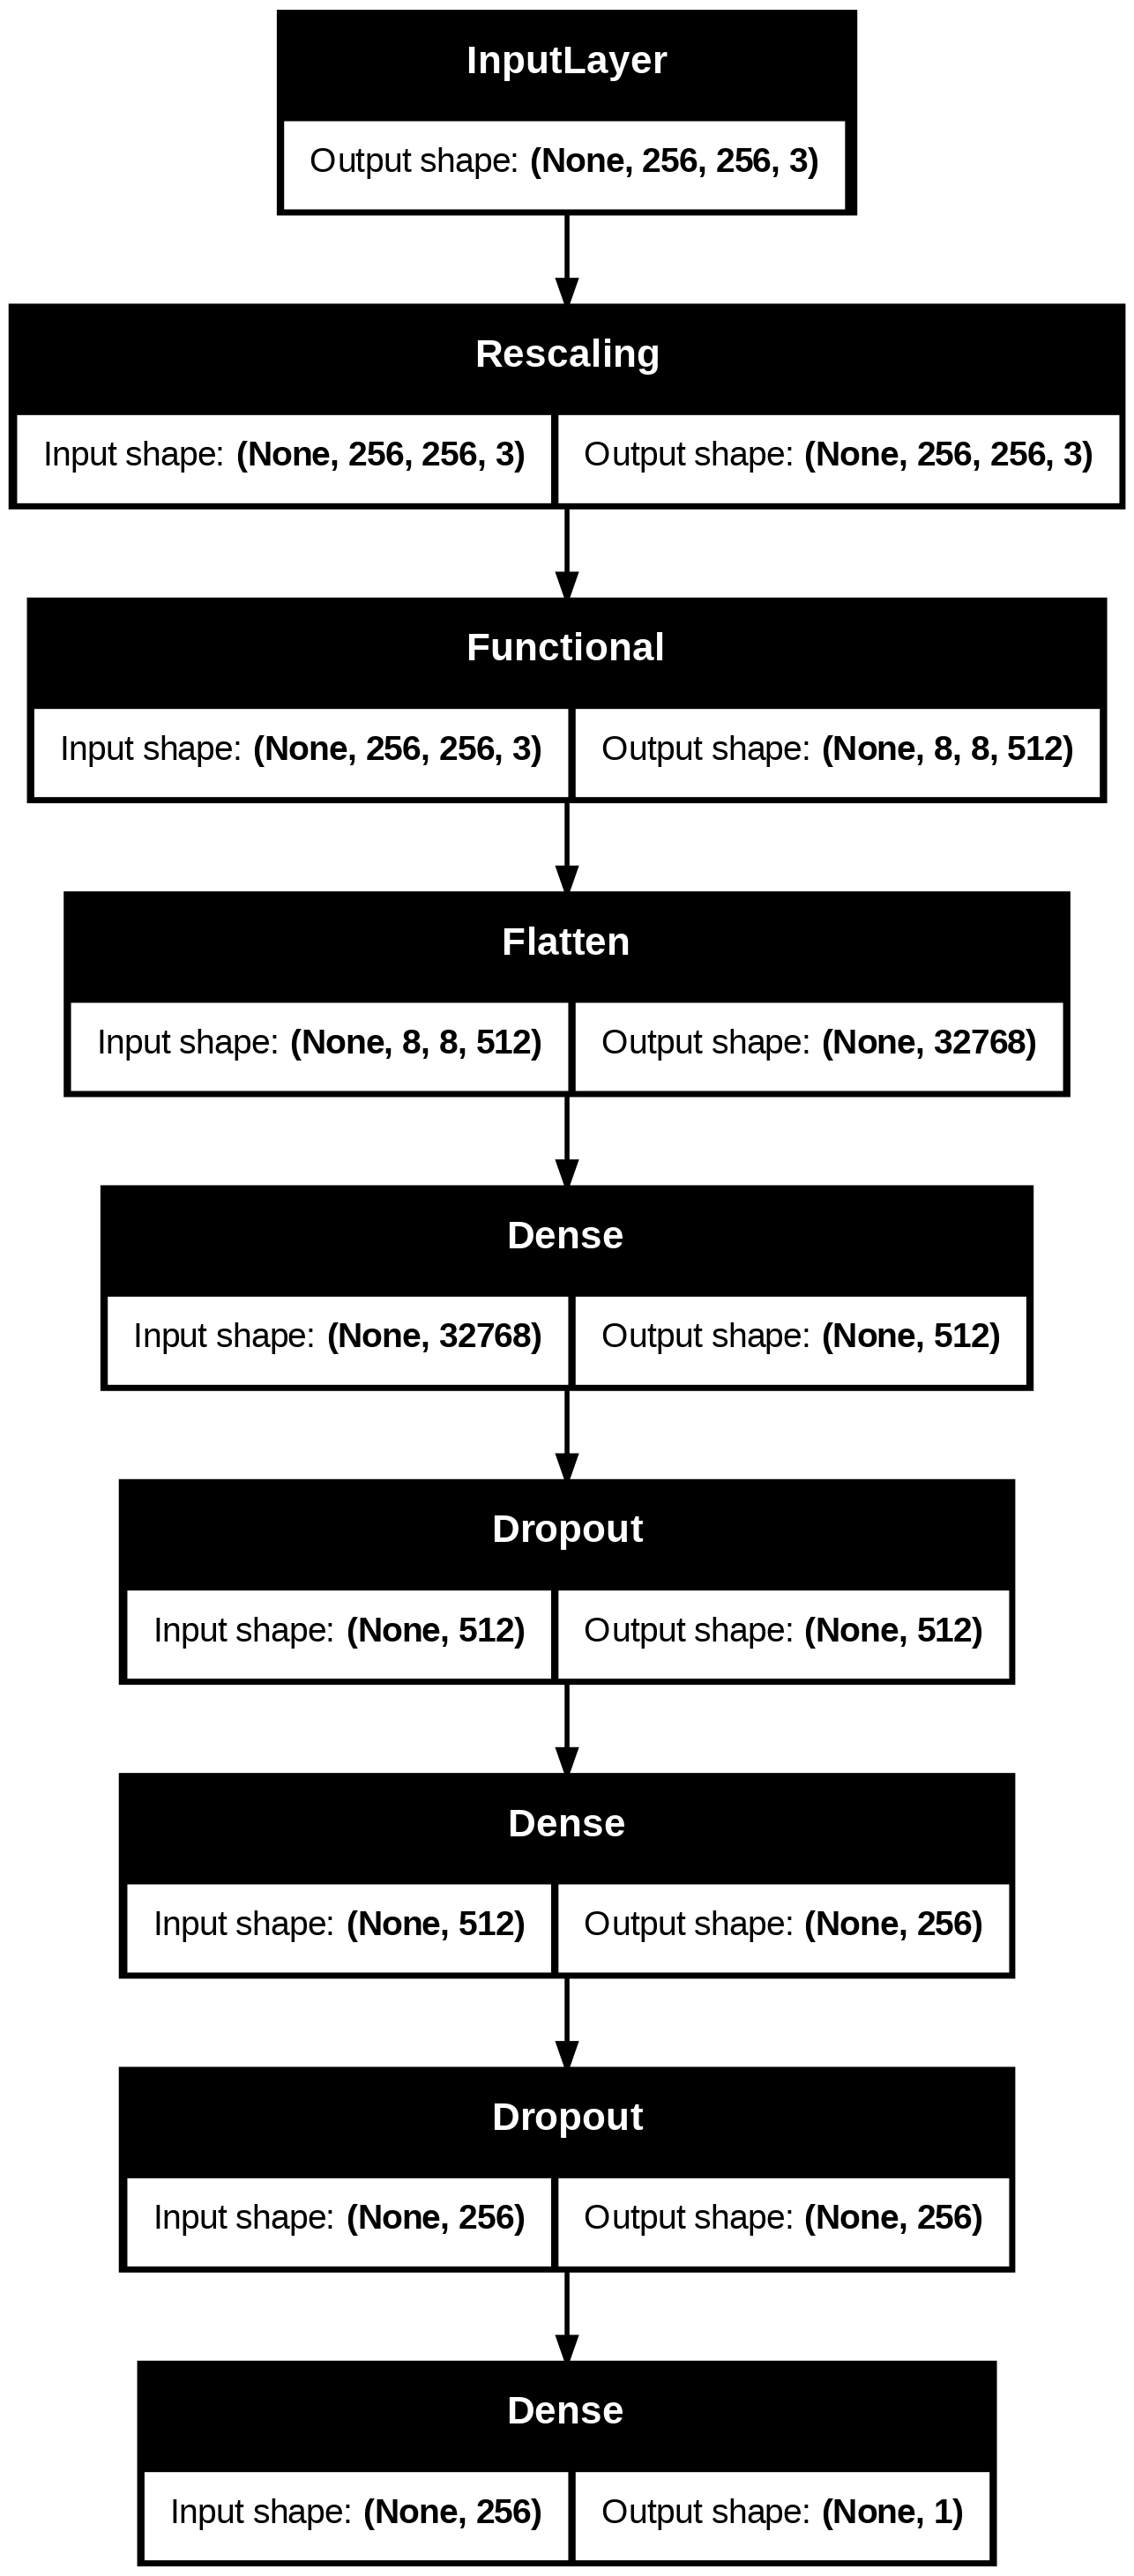

In [17]:
model = tf.keras.models.Model(inputs=inputs, outputs=x)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [18]:
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_1 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_2 (Dropout)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,624,001 (120.64 MB)

 Trainable params: 16,909,313 (64.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # ✅ Correct loss for sigmoid output
    metrics=['accuracy']
)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Callbacks
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        filepath='best_model.h5',              # You can change this to a .keras extension if preferred
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Stop training if validation accuracy doesn't improve
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Log training progress to CSV
    CSVLogger(
        filename='training_log.csv',
        separator=',',
        append=False
    )
]


## Start training and validating results

In [ ]:
n_epoch = 100

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
 31/200 ━━━━━━━━━━━━━━━━━━━━ 37:55 13s/step - accuracy: 0.4831 - loss: 3.0136

In [ ]:
result.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

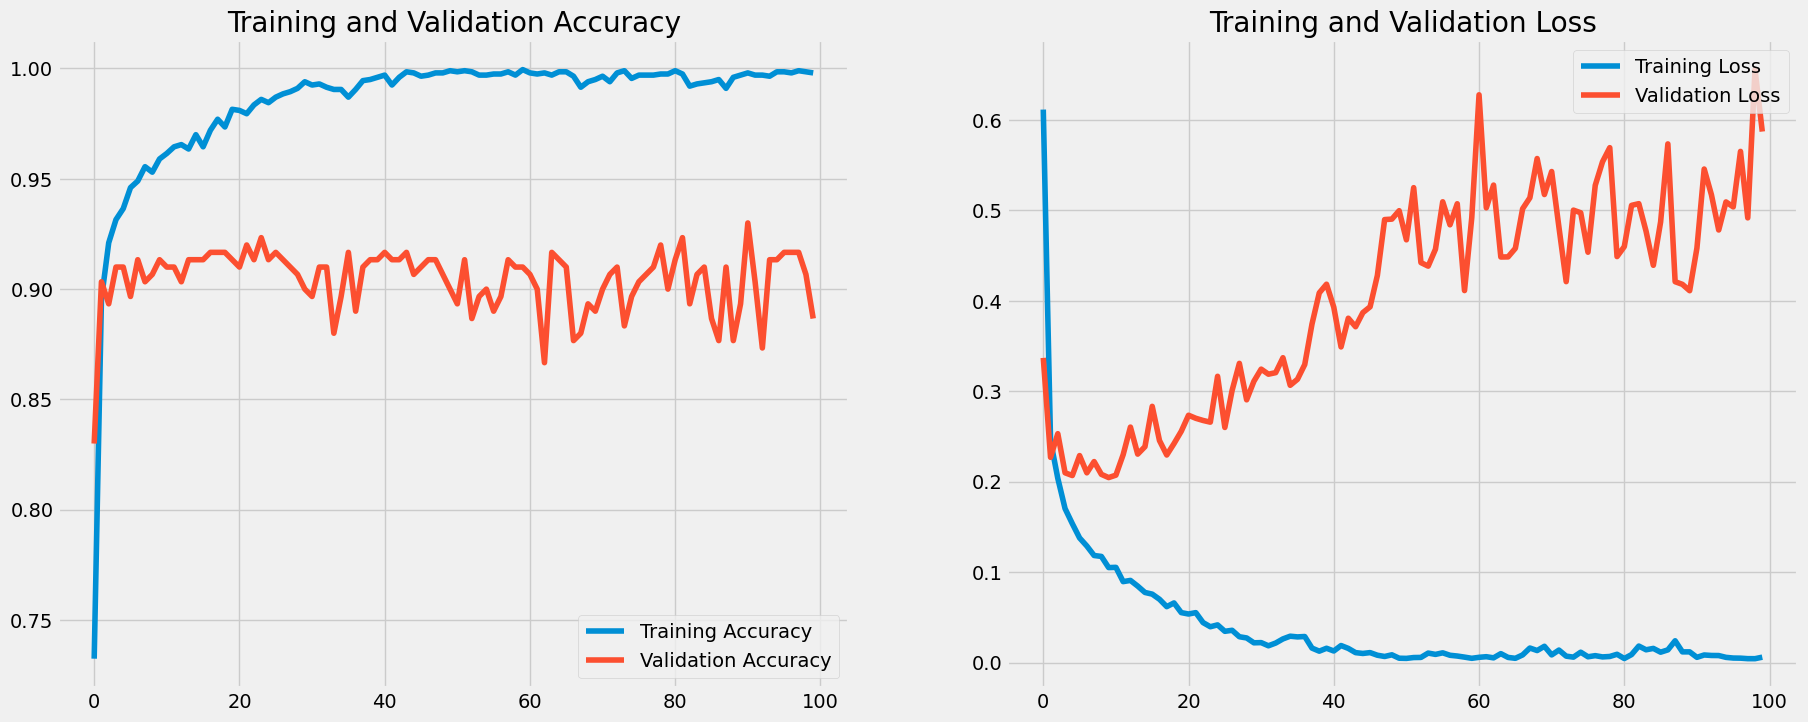

In [ ]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(n_epoch)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing and Evaluation

In [ ]:
model = tf.keras.models.load_model(best_model_ckpt_path)
model

<Functional name=functional, built=True>

In [ ]:
# Evaluate
train_score = model.evaluate(train_ds, verbose=1)
test_score = model.evaluate(test_ds, verbose=1)

# Create DataFrame
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Loss': [train_score[0], test_score[0]],
    'Accuracy': [train_score[1], test_score[1]]
})

# Round values for readability
results_df = results_df.round(3)
results_df.to_csv("results.csv",index=False)
results_df

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.9653 - loss: 0.0854
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.9281 - loss: 0.2148


,Dataset,Loss,Accuracy
0,Train,0.084,0.966
1,Test,0.227,0.923


In [ ]:
label_to_class_mapping

{0: 'defect', 1: 'good'}

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step


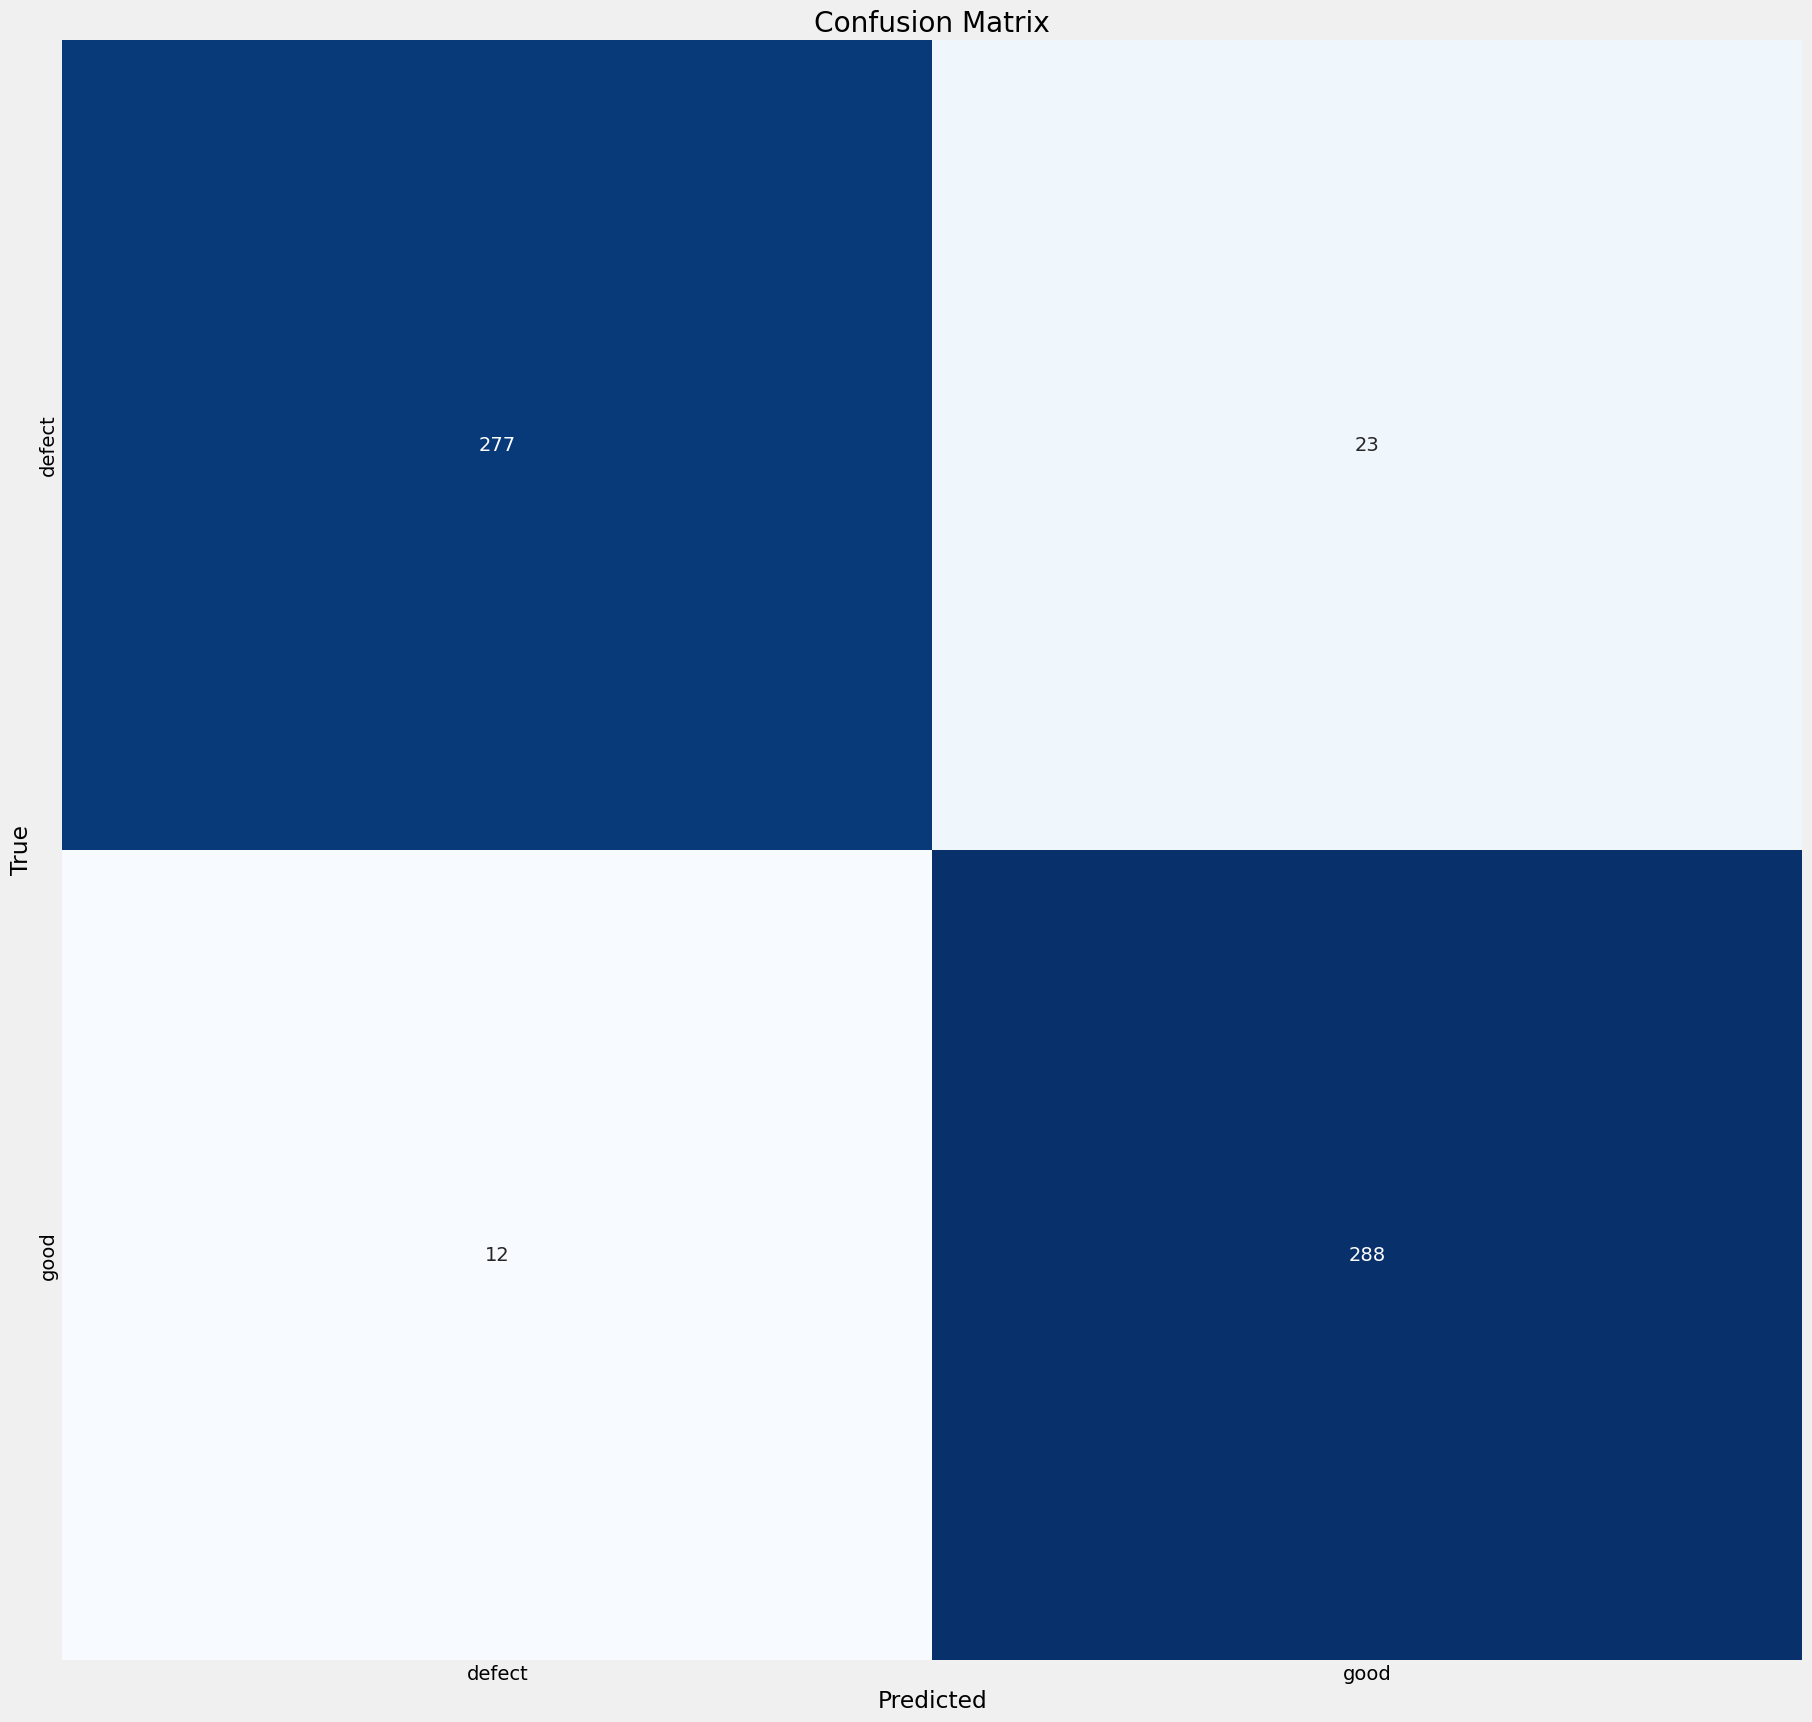

In [ ]:
# Make predictions
y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert logits to class indices

# Get true labels
y_true = np.array([y.numpy() for x, y in val_ds.unbatch()])
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(label_to_class_mapping.values())
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

In [ ]:
# Generate classification report
clr = classification_report(y_true, y_pred_classes, target_names=labels)
print(clr)

# Save to a text file
with open("classification_report.txt", "w") as f:
    f.write(clr)

              precision    recall  f1-score   support

      defect       0.96      0.92      0.94       300
        good       0.93      0.96      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



## Live testing

In [ ]:
def get_model_size(path):
        size = os.path.getsize(path)
        if size < 1024:
            return f"{size} bytes"
        elif size < pow(1024,2):
            return f"{round(size/1024, 2)} KB"
        elif size < pow(1024,3):
            return f"{round(size/(pow(1024,2)), 2)} MB"
        elif size < pow(1024,4):
            return f"{round(size/(pow(1024,3)), 2)} GB"

In [ ]:
model = tf.keras.models.load_model(best_model_ckpt_path)
get_model_size(best_model_ckpt_path)

'69.75 MB'

In [ ]:
img_size

(64, 64)

In [ ]:
label_to_class_mapping

{0: 'defect', 1: 'good'}

In [ ]:
def predict_class(img_path):
    img = Image.open(img_path)
    resized_img = img.resize(img_size).convert("RGB")
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)[0]
    return round(float(np.max(prob)),2), label_to_class_mapping[np.argmax(prob)]

def plot_results(img_path):
    img = Image.open(img_path).convert("RGB")
    resized_img = img.resize(img_size)
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)
    prob = [round(float(i), 5) for i in prob[0]]

    # Sort probabilities and labels based on probability
    sorted_probs, sorted_labels = zip(*sorted(zip(prob, list(label_to_class_mapping.values())), reverse=False))

    # Create a larger plot
    plt.figure(figsize=(10, 8))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.axis('off')  # Hide axes for the image

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    bars = plt.barh(sorted_labels, sorted_probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.5f')

    plt.tight_layout()  # To avoid overlapping subplots
    plt.show()

In [ ]:
sample_data = test_df.drop_duplicates('Class')
sample_data

,Image Path,Class
0,/content/data/test/defect/aug_57b54f71-8c35-4d...,defect
300,/content/data/test/good/022e4e68-83bf-455a-a45...,good


In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[0])
prob,pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(0.97, 'defect')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


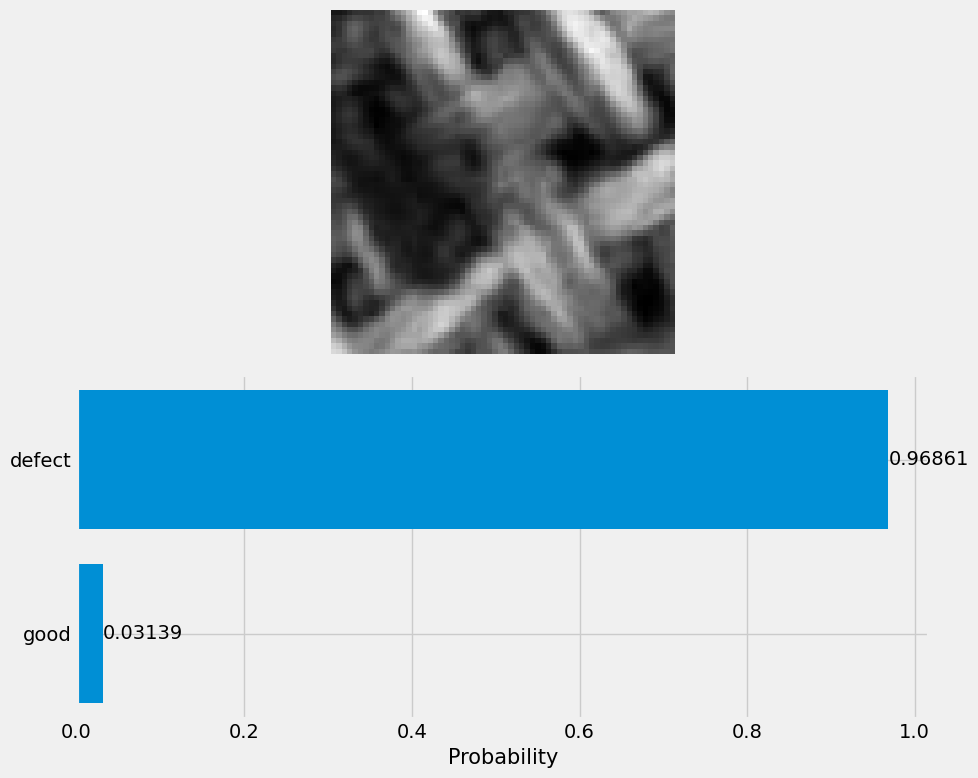

In [ ]:
plot_results(sample_data['Image Path'].values[0])

In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[1])
prob,pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


(0.71, 'good')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


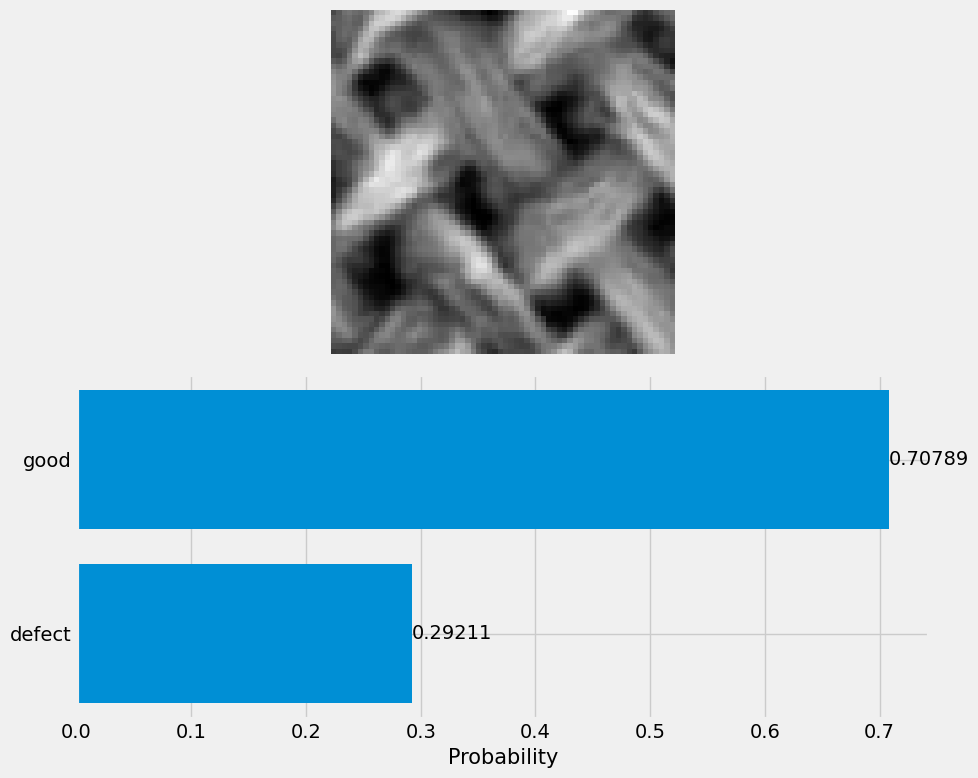

In [ ]:
plot_results(sample_data['Image Path'].values[1])

In [ ]:
train_df.head()

,Image Path,Class
0,/content/data/train/defect/47b7590f-264d-4ff7-...,defect
1,/content/data/train/defect/aug_dd118eb3-0c7f-4...,defect
2,/content/data/train/defect/aug_88132f57-5008-4...,defect
3,/content/data/train/defect/3d2ce924-81b7-4a07-...,defect
4,/content/data/train/defect/712b1d0b-b291-4252-...,defect


In [ ]:
# !rm -rf /content/results_data

In [ ]:
# # Set the threshold for maximum number of images per class
# threshold = 10  # Change this to the desired threshold
# sample_data_path = 'sample_images'
# os.makedirs(sample_data_path, exist_ok=True)

# # Dictionary to keep track of the number of images copied for each class
# class_counts = {}

# # Iterate through each row and save correctly predicted images
# for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     img_path = row['Image Path']
#     true_label = row['Class']
#     confidence, pred_label = predict_class(img_path)

#     if pred_label == true_label:
#         # Check if the class has already reached the threshold
#         if class_counts.get(pred_label, 0) >= threshold:
#             continue  # Skip if the threshold is reached

#         class_folder = os.path.join(sample_data_path, pred_label)
#         os.makedirs(class_folder, exist_ok=True)

#         # Copy the image to the respective folder
#         shutil.copy(img_path, class_folder)

#         # Increment the count for the class
#         class_counts[pred_label] = class_counts.get(pred_label, 0) + 1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  0%|          | 1/1000 [00:00<02:31,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  0%|          | 2/1000 [00:00<03:13,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  0%|          | 3/1000 [00:00<03:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  0%|          | 4/1000 [00:00<03:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  0%|          | 5/1000 [00:01<03:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 6/1000 [00:01<03:36,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  1%|          | 7/1000 [00:01<03:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  1%|          | 8/1000 [00:01<03:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  1%|          | 9/1000 [00:01<03:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  1%|          | 10/1000 [00:02<03:37,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  1%|          | 11/1000 [00:02<03:41,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  1%|          | 12/1000 [00:02<03:40,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▏         | 13/1000 [00:02<03:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|▏         | 14/1000 [00:03<03:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|▏         | 15/1000 [00:03<03:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|▏         | 16/1000 [00:03<04:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  2%|▏         | 17/1000 [00:03<03:53,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|▏         | 18/1000 [00:04<04:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  2%|▏         | 19/1000 [00:04<03:49,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|▏         | 20/1000 [00:04<03:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|▏         | 21/1000 [00:04<04:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|▏         | 22/1000 [00:05<03:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|▏         | 23/1000 [00:05<04:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  2%|▏         | 24/1000 [00:05<04:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  2%|▎         | 25/1000 [00:05<04:11,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  3%|▎         | 26/1000 [00:06<04:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  3%|▎         | 27/1000 [00:06<03:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  3%|▎         | 28/1000 [00:06<03:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  3%|▎         | 29/1000 [00:06<03:09,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  3%|▎         | 30/1000 [00:06<02:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  3%|▎         | 31/1000 [00:06<02:38,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  3%|▎         | 32/1000 [00:06<02:31,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  3%|▎         | 33/1000 [00:07<02:29,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  3%|▎         | 34/1000 [00:07<02:23,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  4%|▎         | 35/1000 [00:07<02:45,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  4%|▎         | 36/1000 [00:07<02:35,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  4%|▎         | 37/1000 [00:07<02:53,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  4%|▍         | 38/1000 [00:08<03:05,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  4%|▍         | 39/1000 [00:08<02:52,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  4%|▍         | 40/1000 [00:08<02:40,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  4%|▍         | 41/1000 [00:08<02:56,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  4%|▍         | 42/1000 [00:08<03:02,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  4%|▍         | 43/1000 [00:09<03:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  4%|▍         | 44/1000 [00:09<03:17,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  4%|▍         | 45/1000 [00:09<03:17,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  5%|▍         | 46/1000 [00:09<03:17,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  5%|▍         | 47/1000 [00:09<03:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  5%|▍         | 48/1000 [00:10<03:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  5%|▍         | 49/1000 [00:10<03:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  5%|▌         | 50/1000 [00:10<03:04,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  5%|▌         | 51/1000 [00:10<02:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  5%|▌         | 52/1000 [00:10<02:59,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  5%|▌         | 53/1000 [00:11<03:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  5%|▌         | 54/1000 [00:11<03:12,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  6%|▌         | 55/1000 [00:11<02:54,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  6%|▌         | 56/1000 [00:11<02:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|▌         | 57/1000 [00:11<02:31,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  6%|▌         | 58/1000 [00:11<02:25,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  6%|▌         | 59/1000 [00:11<02:25,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  6%|▌         | 60/1000 [00:12<02:22,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  6%|▌         | 61/1000 [00:12<02:24,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  6%|▌         | 62/1000 [00:12<02:20,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  6%|▋         | 63/1000 [00:12<02:17,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|▋         | 64/1000 [00:12<02:15,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|▋         | 65/1000 [00:12<02:13,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|▋         | 66/1000 [00:13<02:35,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|▋         | 67/1000 [00:13<02:47,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|▋         | 68/1000 [00:13<02:57,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 69/1000 [00:13<02:44,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 70/1000 [00:13<02:52,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 71/1000 [00:14<03:05,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  7%|▋         | 72/1000 [00:14<02:52,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 73/1000 [00:14<02:42,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 74/1000 [00:14<02:33,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  8%|▊         | 75/1000 [00:14<02:49,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  8%|▊         | 76/1000 [00:14<02:37,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  8%|▊         | 77/1000 [00:15<02:52,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 78/1000 [00:15<02:38,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  8%|▊         | 79/1000 [00:15<02:33,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  8%|▊         | 80/1000 [00:15<02:49,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  8%|▊         | 81/1000 [00:15<02:57,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  8%|▊         | 82/1000 [00:16<03:04,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  8%|▊         | 83/1000 [00:16<03:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  8%|▊         | 84/1000 [00:16<03:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  8%|▊         | 85/1000 [00:16<03:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  9%|▊         | 86/1000 [00:17<03:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|▊         | 87/1000 [00:17<03:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|▉         | 88/1000 [00:17<03:46,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  9%|▉         | 89/1000 [00:17<03:47,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  9%|▉         | 90/1000 [00:18<03:33,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  9%|▉         | 91/1000 [00:18<03:40,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  9%|▉         | 92/1000 [00:18<03:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  9%|▉         | 93/1000 [00:18<03:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|▉         | 94/1000 [00:19<03:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|▉         | 95/1000 [00:19<03:42,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|▉         | 96/1000 [00:19<03:47,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 10%|▉         | 97/1000 [00:19<03:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 10%|▉         | 98/1000 [00:19<03:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 10%|▉         | 99/1000 [00:20<03:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 10%|█         | 100/1000 [00:20<03:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 10%|█         | 101/1000 [00:20<03:09,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 10%|█         | 102/1000 [00:20<02:53,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 10%|█         | 103/1000 [00:20<03:02,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 10%|█         | 104/1000 [00:21<02:44,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 10%|█         | 105/1000 [00:21<02:52,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 11%|█         | 106/1000 [00:21<02:38,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 11%|█         | 107/1000 [00:21<02:31,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 11%|█         | 108/1000 [00:21<02:47,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|█         | 109/1000 [00:22<02:56,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 11%|█         | 110/1000 [00:22<02:38,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 11%|█         | 111/1000 [00:22<02:46,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 11%|█         | 112/1000 [00:22<02:33,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 11%|█▏        | 113/1000 [00:22<02:46,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 11%|█▏        | 114/1000 [00:22<02:33,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 12%|█▏        | 115/1000 [00:23<02:26,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 12%|█▏        | 116/1000 [00:23<02:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 12%|█▏        | 117/1000 [00:23<02:28,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 12%|█▏        | 118/1000 [00:23<02:41,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 12%|█▏        | 119/1000 [00:23<02:36,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 12%|█▏        | 120/1000 [00:24<02:48,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 12%|█▏        | 121/1000 [00:24<02:37,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 12%|█▏        | 122/1000 [00:24<02:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 12%|█▏        | 123/1000 [00:24<02:32,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 12%|█▏        | 124/1000 [00:24<02:21,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 12%|█▎        | 125/1000 [00:24<02:20,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 13%|█▎        | 126/1000 [00:25<02:35,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 13%|█▎        | 127/1000 [00:25<02:45,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 128/1000 [00:25<02:51,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 13%|█▎        | 129/1000 [00:25<02:56,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 13%|█▎        | 130/1000 [00:25<02:44,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 13%|█▎        | 131/1000 [00:26<02:54,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 13%|█▎        | 132/1000 [00:26<02:59,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 13%|█▎        | 133/1000 [00:26<03:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 13%|█▎        | 134/1000 [00:26<03:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 14%|█▎        | 135/1000 [00:26<02:54,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 14%|█▎        | 136/1000 [00:27<02:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 14%|█▎        | 137/1000 [00:27<02:43,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 14%|█▍        | 138/1000 [00:27<02:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 14%|█▍        | 139/1000 [00:27<02:22,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 14%|█▍        | 140/1000 [00:27<02:36,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 14%|█▍        | 141/1000 [00:27<02:45,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 14%|█▍        | 142/1000 [00:28<02:52,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 14%|█▍        | 143/1000 [00:28<02:38,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 14%|█▍        | 144/1000 [00:28<02:30,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 14%|█▍        | 145/1000 [00:28<02:46,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 15%|█▍        | 146/1000 [00:28<02:34,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 15%|█▍        | 147/1000 [00:29<02:49,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 15%|█▍        | 148/1000 [00:29<02:58,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 15%|█▍        | 149/1000 [00:29<02:41,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 15%|█▌        | 150/1000 [00:29<02:52,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|█▌        | 151/1000 [00:29<03:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 15%|█▌        | 152/1000 [00:30<03:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|█▌        | 153/1000 [00:30<03:21,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 15%|█▌        | 154/1000 [00:30<03:26,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|█▌        | 155/1000 [00:31<03:38,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|█▌        | 156/1000 [00:31<03:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|█▌        | 157/1000 [00:31<03:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 16%|█▌        | 158/1000 [00:31<03:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 16%|█▌        | 159/1000 [00:32<03:37,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|█▌        | 160/1000 [00:32<03:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|█▌        | 161/1000 [00:32<03:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|█▌        | 162/1000 [00:32<03:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|█▋        | 163/1000 [00:33<03:30,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 16%|█▋        | 164/1000 [00:33<03:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 16%|█▋        | 165/1000 [00:33<03:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 17%|█▋        | 166/1000 [00:33<03:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 17%|█▋        | 167/1000 [00:33<03:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 17%|█▋        | 168/1000 [00:34<03:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 17%|█▋        | 169/1000 [00:34<02:49,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 17%|█▋        | 170/1000 [00:34<02:34,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 17%|█▋        | 171/1000 [00:34<02:42,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 17%|█▋        | 172/1000 [00:34<02:29,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 17%|█▋        | 173/1000 [00:34<02:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 17%|█▋        | 174/1000 [00:35<02:32,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 18%|█▊        | 175/1000 [00:35<02:24,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 18%|█▊        | 176/1000 [00:35<02:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 18%|█▊        | 177/1000 [00:35<02:25,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 18%|█▊        | 178/1000 [00:35<02:34,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 18%|█▊        | 179/1000 [00:36<02:45,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 18%|█▊        | 180/1000 [00:36<02:30,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 18%|█▊        | 181/1000 [00:36<02:23,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 18%|█▊        | 182/1000 [00:36<02:35,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 18%|█▊        | 183/1000 [00:36<02:23,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 18%|█▊        | 184/1000 [00:36<02:33,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 18%|█▊        | 185/1000 [00:37<02:23,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 19%|█▊        | 186/1000 [00:37<02:33,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 19%|█▊        | 187/1000 [00:37<02:20,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 19%|█▉        | 188/1000 [00:37<02:32,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 19%|█▉        | 189/1000 [00:37<02:39,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 19%|█▉        | 190/1000 [00:38<02:45,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 19%|█▉        | 191/1000 [00:38<02:50,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 19%|█▉        | 192/1000 [00:38<02:53,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 19%|█▉        | 193/1000 [00:38<02:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 19%|█▉        | 194/1000 [00:39<02:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 20%|█▉        | 195/1000 [00:39<02:57,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 20%|█▉        | 196/1000 [00:39<02:42,  4.96it/s]


KeyboardInterrupt: 

In [ ]:
# !rm -rf /content/drive/MyDrive/saved_model/

In [ ]:
# !ls

In [ ]:
# !mkdir -p /content/drive/MyDrive/saved_model/
# !mv /content/*best_model.keras /content/drive/MyDrive/saved_model/.
# !mv /content/model.png /content/drive/MyDrive/saved_model/.
# !mv /content/training_log.csv /content/drive/MyDrive/saved_model/.
# !mv /content/sample_images /content/drive/MyDrive/saved_model/.
# !mv /content/classification_report.txt /content/drive/MyDrive/saved_model/.
# !mv /content/label_to_class_mapping.json /content/drive/MyDrive/saved_model/.
# !mv /content/model_summary.txt /content/drive/MyDrive/saved_model/.
# !mv /content/confusion_matrix.png /content/drive/MyDrive/saved_model/.
# !mv /content/results.csv /content/drive/MyDrive/saved_model/.